In [1]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from matplotlib import colors
import matplotlib.pyplot as plt
from topopt.utils import id_to_xy
import openmdao.api as om
from lca4mdao.component import LcaCalculationComponent
from lca4mdao.utilities import cleanup_parameters, setup_bw
from lca4mdao.variable import ExplicitComponentLCA
%matplotlib notebook

In [2]:
table_E = [1, 1]
table_nu = [0.3, 0.3]

In [3]:
nelx = 180
nely = 60
nelx = 90
nely = 30
volfrac = 0.4
rmin = 5.4
penal = 3.0
# ft = 1  # ft==0 -> sens, ft==1 -> dens

debug = False

In [4]:
def topopt_setup(nelx, nely):
    # BC's and support
    dofs = np.arange(2 * (nelx + 1) * (nely + 1))
    ndof = 2 * (nelx + 1) * (nely + 1)
    # fixed =np.union1d(dofs[0:2*(nely+1):2],np.array([2*(nelx+1)*(nely+1)-1]))
    # fixed = np.union1d(dofs[0:(nely + 1):2], np.array([2 * (nelx + 1) * (nely + 1) - 1]))
    # fixed = np.union1d(dofs[0:3:2], np.array([2 * (nelx + 1) * (nely + 1) - 1]))
    fixed = np.union1d(dofs[2 * nely:2 * (nely + 1)], np.array([2 * (nelx + 1) * (nely + 1) - 1]))
    # fixed = np.union1d(dofs[0:2], np.array([2 * (nelx + 1) * (nely + 1) - 1]))

    free = np.setdiff1d(dofs, fixed)
    # print(fixed, free)

    # Solution and RHS vectors
    f = np.zeros((ndof, 1))
    u = np.zeros((ndof, 1))

    # Set load
    # f[1, 0] = -1
    # f[2, 0] = -1
    f[(nelx + 1) * (nely + 1), 0] = -1
    return dofs, fixed, free, f, u

In [5]:
def lk(material_type=0):
    E = table_E[material_type]
    nu = table_nu[material_type]
    k = np.array(
        [1 / 2 - nu / 6, 1 / 8 + nu / 8, -1 / 4 - nu / 12, -1 / 8 + 3 * nu / 8, -1 / 4 + nu / 12, -1 / 8 - nu / 8,
         nu / 6, 1 / 8 - 3 * nu / 8])
    KE = E / (1 - nu ** 2) * np.array([[k[0], k[1], k[2], k[3], k[4], k[5], k[6], k[7]],
                                       [k[1], k[0], k[7], k[6], k[5], k[4], k[3], k[2]],
                                       [k[2], k[7], k[0], k[5], k[6], k[3], k[4], k[1]],
                                       [k[3], k[6], k[5], k[0], k[7], k[2], k[1], k[4]],
                                       [k[4], k[5], k[6], k[7], k[0], k[1], k[2], k[3]],
                                       [k[5], k[4], k[3], k[2], k[1], k[0], k[7], k[6]],
                                       [k[6], k[3], k[4], k[1], k[2], k[7], k[0], k[5]],
                                       [k[7], k[2], k[1], k[4], k[3], k[6], k[5], k[0]]]);
    return (KE)

In [6]:
def plot_force_arrows(nelx, nely, f, ax):
    """Add arrows to the plot for each force."""
    arrowprops = {"arrowstyle": "->", "connectionstyle": "arc3", "lw": 2,
                  "color": 0}
    cmap = plt.get_cmap("hsv", f.shape[1] + 1)
    for load_i in range(f.shape[1]):
        nz = np.nonzero(f[:, load_i])
        arrowprops["color"] = cmap(load_i)
        for i in range(nz[0].shape[0]):
            x, y = id_to_xy(nz[0][i] // 2, nelx, nely)
            x = max(min(x, nelx - 1), 0)
            y = max(min(y, nely - 1), 0)
            z = int(nz[0][i] % 2)
            mag = -50 * f[nz[0][i], load_i]
            ax.annotate(
                "", xy=(x, y), xycoords="data",
                xytext=(0 if z else mag, mag if z else 0),
                textcoords="offset points", arrowprops=arrowprops)

In [7]:
class Structure(ExplicitComponentLCA):
    """
    Base component based on topopt
    """
    def initialize(self):
        self.options.declare('nelx', types=int)
        self.options.declare('nely', types=int)
        self.options.declare('volfrac', types=float)
        self.options.declare('rmin', types=float)
        self.options.declare('penal', types=float)
        
        self.options.declare('plot', types=bool)

    def setup(self):
        nelx = self.options['nelx']
        nely = self.options['nely']
        volfrac = self.options['volfrac']
        self.add_input('x', val=volfrac * np.ones(nely * nelx, dtype=float))
        self.add_output('obj')

    def setup_partials(self):
        self.declare_partials('obj', 'x')

    def compute(self, inputs, outputs):
        nelx = self.options['nelx']
        nely = self.options['nely']
        x = inputs['x']
        # Max and min stiffness
        Emin = 1e-9
        Emax = 1.0
        # dofs:
        ndof = 2 * (nelx + 1) * (nely + 1)
        dofs, fixed, free, f, u = topopt_setup(nelx, nely)
        
        ### this block can be taken out
        
        # FE: Build the index vectors for the for coo matrix format.
        KE = lk(1)
        edofMat = np.zeros((nelx * nely, 8), dtype=int)
        for elx in range(nelx):
            for ely in range(nely):
                el = ely + elx * nely
                n1 = (nely + 1) * elx + ely
                n2 = (nely + 1) * (elx + 1) + ely
                edofMat[el, :] = np.array(
                    [2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3, 2 * n2, 2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        # Construct the index pointers for the coo format
        iK = np.kron(edofMat, np.ones((8, 1))).flatten()
        jK = np.kron(edofMat, np.ones((1, 8))).flatten()
        """
        # Filter: Build (and assemble) the index+data vectors for the coo matrix format
        nfilter = int(nelx * nely * ((2 * (np.ceil(rmin) - 1) + 1) ** 2))
        iH = np.zeros(nfilter)
        jH = np.zeros(nfilter)
        sH = np.zeros(nfilter)
        cc = 0
        for i in range(nelx):
            for j in range(nely):
                row = i * nely + j
                kk1 = int(np.maximum(i - (np.ceil(rmin) - 1), 0))
                kk2 = int(np.minimum(i + np.ceil(rmin), nelx))
                ll1 = int(np.maximum(j - (np.ceil(rmin) - 1), 0))
                ll2 = int(np.minimum(j + np.ceil(rmin), nely))
                for k in range(kk1, kk2):
                    for l in range(ll1, ll2):
                        col = k * nely + l
                        fac = rmin - np.sqrt(((i - k) * (i - k) + (j - l) * (j - l)))
                        iH[cc] = row
                        jH[cc] = col
                        sH[cc] = np.maximum(0.0, fac)
                        cc = cc + 1
        # Finalize assembly and convert to csc format
        H = coo_matrix((sH, (iH, jH)), shape=(nelx * nely, nelx * nely)).tocsc()
        Hs = H.sum(1)
        """
        
        sK = ((KE.flatten()[np.newaxis]).T * (Emin + (x) ** penal * (Emax - Emin))).flatten(order='F')
        K = coo_matrix((sK, (iK, jK)), shape=(ndof, ndof)).tocsc()
        # Remove constrained dofs from matrix
        K = K[free, :][:, free]
        # Solve system
        u[free, 0] = spsolve(K, f[free, 0])
        # Objective and sensitivity
        dc = np.ones(nely * nelx)
        ce = np.ones(nely * nelx)
        ce[:] = (np.dot(u[edofMat].reshape(nelx * nely, 8), KE) * u[edofMat].reshape(nelx * nely, 8)).sum(1)
        
        obj = ((Emin + x ** penal * (Emax - Emin)) * ce).sum()
        dc[:] = (-penal * x ** (penal - 1) * (Emax - Emin)) * ce
        
        # print(u, ce, x, obj, dc)
        
        outputs['obj'] = obj
        
        # Plot to screen
        if self.options['plot']:
            global im
            global fig
            im.set_array(-x.reshape((nelx, nely)).T)
            fig.canvas.draw()
        
        
    def compute_partials(self, inputs, partials):
        nelx = self.options['nelx']
        nely = self.options['nely']
        x = inputs['x']
        # Max and min stiffness
        Emin = 1e-9
        Emax = 1.0
        # dofs:
        ndof = 2 * (nelx + 1) * (nely + 1)
        dofs, fixed, free, f, u = topopt_setup(nelx, nely)
        
        ### this block can be taken out
        
        # FE: Build the index vectors for the for coo matrix format.
        KE = lk(1)
        edofMat = np.zeros((nelx * nely, 8), dtype=int)
        for elx in range(nelx):
            for ely in range(nely):
                el = ely + elx * nely
                n1 = (nely + 1) * elx + ely
                n2 = (nely + 1) * (elx + 1) + ely
                edofMat[el, :] = np.array(
                    [2 * n1 + 2, 2 * n1 + 3, 2 * n2 + 2, 2 * n2 + 3, 2 * n2, 2 * n2 + 1, 2 * n1, 2 * n1 + 1])
        # Construct the index pointers for the coo format
        
        iK = np.kron(edofMat, np.ones((8, 1))).flatten()
        jK = np.kron(edofMat, np.ones((1, 8))).flatten()
        """
        # Filter: Build (and assemble) the index+data vectors for the coo matrix format
        nfilter = int(nelx * nely * ((2 * (np.ceil(rmin) - 1) + 1) ** 2))
        iH = np.zeros(nfilter)
        jH = np.zeros(nfilter)
        sH = np.zeros(nfilter)
        cc = 0
        for i in range(nelx):
            for j in range(nely):
                row = i * nely + j
                kk1 = int(np.maximum(i - (np.ceil(rmin) - 1), 0))
                kk2 = int(np.minimum(i + np.ceil(rmin), nelx))
                ll1 = int(np.maximum(j - (np.ceil(rmin) - 1), 0))
                ll2 = int(np.minimum(j + np.ceil(rmin), nely))
                for k in range(kk1, kk2):
                    for l in range(ll1, ll2):
                        col = k * nely + l
                        fac = rmin - np.sqrt(((i - k) * (i - k) + (j - l) * (j - l)))
                        iH[cc] = row
                        jH[cc] = col
                        sH[cc] = np.maximum(0.0, fac)
                        cc = cc + 1
        # Finalize assembly and convert to csc format
        H = coo_matrix((sH, (iH, jH)), shape=(nelx * nely, nelx * nely)).tocsc()
        Hs = H.sum(1)
        """
        
        sK = ((KE.flatten()[np.newaxis]).T * (Emin + (x) ** penal * (Emax - Emin))).flatten(order='F')
        K = coo_matrix((sK, (iK, jK)), shape=(ndof, ndof)).tocsc()
        # Remove constrained dofs from matrix
        K = K[free, :][:, free]
        # Solve system
        u[free, 0] = spsolve(K, f[free, 0])
        # Objective and sensitivity
        dc = np.ones(nely * nelx)
        ce = np.ones(nely * nelx)
        ce[:] = (np.dot(u[edofMat].reshape(nelx * nely, 8), KE) * u[edofMat].reshape(nelx * nely, 8)).sum(1)
        obj = ((Emin + x ** penal * (Emax - Emin)) * ce).sum()
        dc[:] = (-penal * x ** (penal - 1) * (Emax - Emin)) * ce
        
        partials['obj', 'x'] = dc

In [8]:
structure = Structure(nelx=nelx, nely=nely, volfrac=volfrac, rmin=rmin, penal=penal, plot=True)

<IPython.core.display.Javascript object>


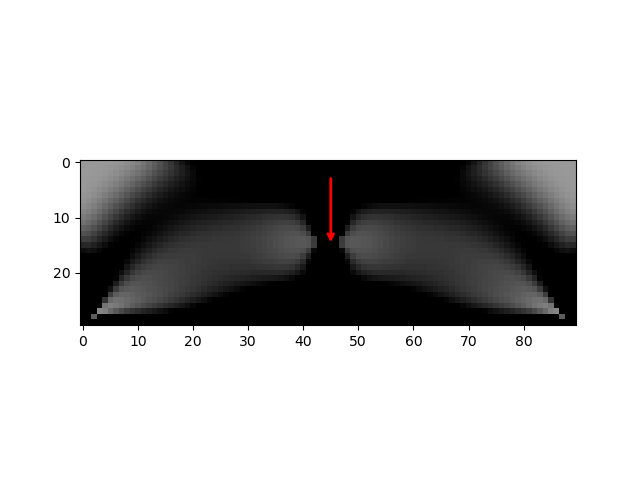

In [9]:
if structure.options['plot']:
    nelx = structure.options['nelx']
    nely = structure.options['nely']
    volfrac = structure.options['volfrac']
    plt.ion()  # Ensure that redrawing is possible
    fig, ax = plt.subplots()
    x_def=volfrac*np.ones(nely * nelx, dtype=float)
    im = ax.imshow(x_def.reshape((nelx, nely)).T, cmap='gray', \
                   interpolation='none', norm=colors.Normalize(vmin=-1, vmax=0))
    fig.show()
    _, _, _, f, _ = topopt_setup(nelx, nely)
    plot_force_arrows(nelx, nely, f, ax)
    fig.canvas.draw()

In [ ]:
check_partials = False

prob = om.Problem()
prob.model = om.Group()
prob.model.add_subsystem('structure', structure, promotes=['x','obj'])

prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['maxiter'] = 200
prob.driver.options['tol'] = 1e-6
#prob.driver.options['debug_print'] = ['desvars', 'objs']
prob.driver.options['debug_print'] = ['objs']

prob.model.add_design_var('x', lower=1e-3, upper=1)
prob.model.add_objective('obj')

prob.setup()
prob.run_model()
if check_partials:
    print('Checking partial derivatives:')
    prob.check_partials(compact_print=True, includes='*', )
prob.set_solver_print(level=2)
print('Running;')
prob.run_driver()

print('minimum found at')
print(prob.get_val('x'))
print('with objective:')
print(prob.get_val('obj')[0])

Running;
Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|0
--------------------------------------------------------------
Objectives
{'structure.obj': array([213.98417064])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|1
--------------------------------------------------------------
Objectives
{'structure.obj': array([213.98417064])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|2
--------------------------------------------------------------
Objectives
{'structure.obj': array([21.37714265])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|3
--------------------------------------------------------------
Objectives
{'structure.obj': array([19.90229938])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|4
--------------------------------------------------------------
Objectives
{'structure.obj': array([16.98714198])}

Driver debug print for iter coord: rank0:ScipyOptimize_SLSQP|5
------------------------------------